# Analysis: air quality vs happiness index

In [176]:
# Dependencies
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from pprint import pprint
from scipy import stats

# Dependencies (local modules)
from countries import get_country

## Import air quality and happiness index
### Cleaned datasets
- cleaned_happiness_index.csv
- cleaned_airquality.csv

In [177]:
# Import CSV to DataFrames
csv_airquality = Path("Cleaned_Datasets/cleaned_airquality.csv")
csv_happiness = Path("Cleaned_Datasets/cleaned_happiness_index.csv")

airquality_df = pd.read_csv(csv_airquality)
happiness_df = pd.read_csv(csv_happiness)

In [178]:
# Air quality data uses country code instead of country name

# Iterate through the DataFrame
for index, row in airquality_df.iterrows():
    # Replace the country code by the country name
    airquality_df.loc[index,'Country'] = get_country(airquality_df.loc[index,'Country'])

# List all the countries in the air quality DataFrame
airquality_countries = airquality_df['Country'].unique().tolist()
print(f"{len(airquality_countries)} countries found.")
pprint(airquality_countries)

93 countries found.
['United Arab Emirates',
 'Afghanistan',
 'Argentina',
 'Austria',
 'Australia',
 'Bosnia and Herzegovina',
 'Bangladesh',
 'Belgium',
 'Bulgaria',
 'Bahrain',
 'Brazil',
 'Canada',
 'Switzerland',
 "Cote d'Ivoire",
 'Chile',
 'China',
 'Colombia',
 'Costa Rica',
 'Curaçao',
 'Cyprus',
 'Czechia',
 'Germany',
 'Denmark',
 'Algeria',
 'Ecuador',
 'Estonia',
 'Spain',
 'Ethiopia',
 'Finland',
 'France',
 'United Kingdom of Great Britain and Northern Ireland',
 'Georgia',
 'Ghana',
 'Guinea',
 'Greece',
 'Guatemala',
 'Hong Kong',
 'Croatia',
 'Hungary',
 'Indonesia',
 'Ireland',
 'Israel',
 'India',
 'Iraq',
 'Iran (Islamic Republic of)',
 'Iceland',
 'Italy',
 'Jordan',
 'Japan',
 'Kyrgyzstan',
 'Republic of Korea',
 'Kuwait',
 'Kazakhstan',
 "Lao People's Democratic Republic",
 'Sri Lanka',
 'Lithuania',
 'North Macedonia',
 'Mali',
 'Myanmar',
 'Mongolia',
 'Macao',
 'Mexico',
 'The Netherlands',
 'Norway',
 'Nepal',
 'New Zealand',
 'Peru',
 'Philippines',
 'Pakis

In [181]:
#reformat Happiness index df to same format as air quality df

# Create a list of years
years = [str(year) for year in range(2015, 2020)]

# Create an empty DataFrame to store the reformatted data
happiness_reformatted = pd.DataFrame()

# Iterate over the years and extract the 'Rank' and 'Score' columns for each year
for year in years:
    rank_column = 'Rank ' + year
    score_column = 'Score ' + year

    year_data = pd.DataFrame()
    year_data['Country'] = happiness_df['Country']
    year_data['Year'] = [year] * len(happiness_df)
    year_data['Rank'] = happiness_df[rank_column]
    year_data['Score'] = happiness_df[score_column]

    happiness_reformatted = pd.concat([happiness_reformatted, year_data], ignore_index=True)

# Display the reformatted 'Happiness' DataFrame
happiness_reformatted.head()




,Country,Year,Rank,Score
0,Switzerland,2015,1,7.587
1,Iceland,2015,2,7.561
2,Denmark,2015,3,7.527
3,Norway,2015,4,7.522
4,Canada,2015,5,7.427


In [133]:
# Convert the 'Year' column to a consistent data type in both DataFrames
airquality_df['Year'] = airquality_df['Year'].astype(str)
happiness_reformatted['Year'] = happiness_reformatted['Year'].astype(str)


In [134]:
# Drop the rows with '0' values in the 'Rank' and 'Score' columns
happiness_reformatted = happiness_reformatted[(happiness_reformatted['Rank'] != 0) & (happiness_reformatted['Score'] != 0)]

# Reset the index of the DataFrame
happiness_reformatted = happiness_reformatted.reset_index(drop=True)

happiness_reformatted.head(10)

,Country,Year,Rank,Score
0,Switzerland,2015,1,7.587
1,Iceland,2015,2,7.561
2,Denmark,2015,3,7.527
3,Norway,2015,4,7.522
4,Canada,2015,5,7.427
5,Finland,2015,6,7.406
6,Netherlands,2015,7,7.378
7,Sweden,2015,8,7.364
8,New Zealand,2015,9,7.286
9,Australia,2015,10,7.284


## Merge DataFrames
- Merged on country and year
- Only countries and years present in both files are kept

In [135]:
# Merge the two DataFrames and keep only the countries that are in both
analysis_df = pd.merge(airquality_df, happiness_reformatted, on=["Country", "Year"], how="inner")

# Sort the DataFrame by 'Year' and rest index
analysis_df = analysis_df.sort_values('Year')
analysis_df = analysis_df.reset_index(drop=True)
analysis_df.head()

,Country,Year,PM25,Rank,Score
0,United Arab Emirates,2015,118.714286,20,6.901
1,Taiwan,2015,70.597296,38,6.298
2,Chile,2015,74.443741,27,6.670
3,China,2015,120.768659,84,5.140
4,Colombia,2015,74.106977,33,6.477


## Data Analysis

### Correlation between Happiness Rank and Air Quality (PM25)
Overall correlation for Air Quality(PM25) and Happiness Rank for all countries and all years at once.

R-value: 0.62
Linear model: [Rank] = 0.6884 * [PM25] + 5.84


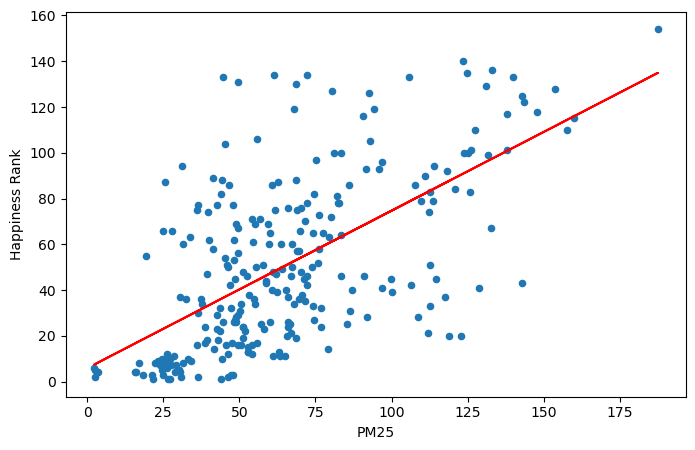

In [136]:
# Show a scatter plot of PM25 versus Happiness Ranking for all countries and all years
ax = analysis_df.plot.scatter(x='PM25',y='Rank', figsize=(8,5))

ax.set_ylabel('Happiness Rank')
# Create a linear regression model based on the PM25 and Happiness Rank data
x_data = analysis_df['PM25']
y_data = analysis_df['Rank']
[slope, intercept, rvalue, pvalue, stdeve] = stats.linregress(x_data,y_data)
print(f"R-value: {rvalue:.2f}")
print(f"Linear model: [Rank] = {slope:.4f} * [PM25] + {intercept:.2f}")

y_reg = slope*x_data+intercept
plt.plot(x_data,y_reg,'r')

# Show plot
plt.show()

### Correlation between Happiness Score and Air Quality (PM25)
Overall correlation for Air Quality(PM25) and Happiness Score for all countries and all years at once.

R-value: -0.64
Linear model: [Rank] = -0.0181 * [PM25] + 7.26


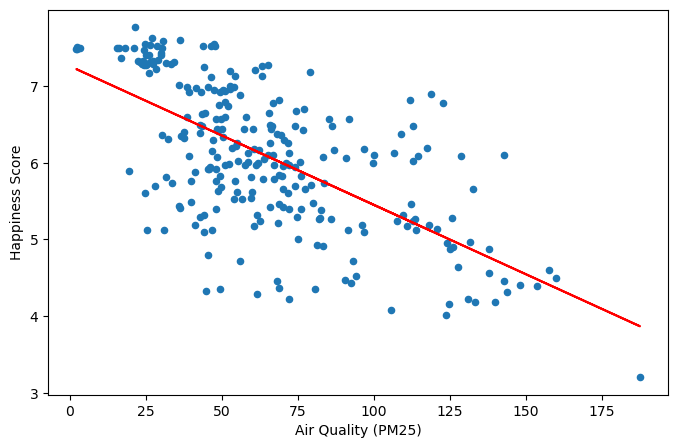

In [161]:
# Show a scatter plot of PM25 versus Score for all countries and all years
ax = analysis_df.plot.scatter(x='PM25',y='Score', figsize=(8,5))

ax.set_ylabel('Happiness Score')
ax.set_xlabel('Air Quality (PM25)')
# Create a linear regression model based on the PM25 and Happiness Rank data
x_data = analysis_df['PM25']
y_data = analysis_df['Score']
[slope, intercept, rvalue, pvalue, stdeve] = stats.linregress(x_data,y_data)
print(f"R-value: {rvalue:.2f}")
print(f"Linear model: [Rank] = {slope:.4f} * [PM25] + {intercept:.2f}")

y_reg = slope*x_data+intercept
plt.plot(x_data,y_reg,'r')

# Show plot
plt.show()

### Graph the average Air Quality(PM25 value) across the top and bottom ranked countries
Top Countries will be any country that has achieved a Happiness Rank of <=10<br>
Bottom Countries will be any country that returned a Happiness Rank of >=92<br>
This returns 42 top/bottom countries in each new DF - ensuring sample size of 42 datasets in each new DF<br>

In [147]:
top_countries_df = analysis_df.loc[analysis_df['Rank'] <= 10]
top_countries_df = top_countries_df.sort_values('Rank')

top_countries_df.count()

Country    42
Year       42
PM25       42
Rank       42
Score      42
dtype: int64

In [149]:
bottom_countries_df = analysis_df.loc[analysis_df['Rank'] >=92]
bottom_countries_df = bottom_countries_df.sort_values('Rank')

bottom_countries_df.count()

Country    42
Year       42
PM25       42
Rank       42
Score      42
dtype: int64

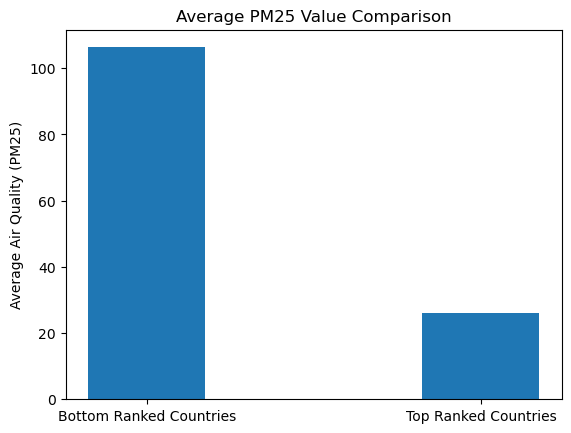

In [183]:
# Calculate the PM25 Mean across both Top Countries and Bottom Countries dataframes
bottom_mean = bottom_countries_df['PM25'].mean()
top_mean = top_countries_df['PM25'].mean()

# Create a bar plot to compare the average PM25 values
labels = ['Bottom Ranked Countries', 'Top Ranked Countries']
mean_values = [bottom_mean, top_mean]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects = ax.bar(x, mean_values, width)

ax.set_ylabel('Average Air Quality (PM25)')
ax.set_title('Average PM25 Value Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()


### Scatter Plot to show all Air Quality (PM25) values for the top and bottom ranked countries. 

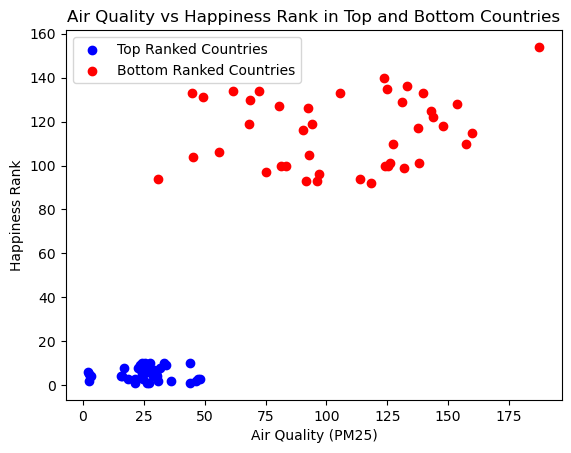

In [173]:
# Looking at 42 top countries and 42 bottom countries per above
# Create a scatter plot to visualise the two ends of the spectrum
plt.scatter(top_countries_df['PM25'], top_countries_df['Rank'], color='blue', label='Top Ranked Countries')

# Create a scatter plot of the bottom countries
plt.scatter(bottom_countries_df['PM25'], bottom_countries_df['Rank'], color='red', label='Bottom Ranked Countries')

# Add a title and labels to the axes
plt.title('Air Quality vs Happiness Rank in Top and Bottom Countries')
plt.ylabel('Happiness Rank')
plt.xlabel('Air Quality (PM25)')

# Add a legend
plt.legend()

#Show the plot
plt.show()